# Free size optimization 
[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meyer-nils/torch-fem/blob/main/examples/optimization/shell/freesize.ipynb)

In [1]:
from math import sqrt

import matplotlib.pyplot as plt
import meshzoo
import torch
from tqdm import tqdm

from torchfem import Shell
from torchfem.materials import IsotropicElasticityPlaneStress

torch.set_default_dtype(torch.float64)

In [2]:
# Material parameters (Cs is transverse shear stiffness)
mat = IsotropicElasticityPlaneStress(E=200000.0, nu=0.3)

# Define nodes and element of the cantilever
X = torch.linspace(0.0, 100.0, 9)
Y = torch.linspace(0.0, 50.0, 9)
points, cells = meshzoo.rectangle_tri(X, Y, variant="zigzag")
N = len(points)
nodes = torch.hstack([torch.tensor(points, dtype=torch.float32), torch.zeros((N, 1))])
elements = torch.tensor(cells.tolist())

# Define Shell model
cantilever = Shell(nodes, elements, mat)

# Define masks for boundaries
left = nodes[:, 0] < 0.01
tip = (nodes[:, 0] > 99.9) & (nodes[:, 1] < 25.01) & (nodes[:, 1] > 24.99)

# Apply load boundary conditions
cantilever.forces[tip, 2] = 50

# Apply displacement boundary conditions
cantilever.constraints[left] = True

In [3]:
from scipy.optimize import bisect

# Parameters
iter = 100
vol_frac = 0.5
s = 0.7

# Initial thickness, minimum thickness, maximum thickness
d_0 = 2.5 * torch.ones(len(cantilever.elements), requires_grad=True)
d_min = 0.1 * torch.ones(len(cantilever.elements))
d_max = 5.0 * torch.ones(len(cantilever.elements))

# Compute element-wise areas with one-point integration
areas = cantilever.char_lengths**2

# Initial volume (50% of maximum available design volume)
V_0 = vol_frac * torch.inner(d_max, areas)

# Lists for compliances, thickness results and asymptotes
comp = []
d = [d_0]
L = []

# Iterate solutions
for k in tqdm(range(iter)):
    # Solve the problem at d_k
    cantilever.thickness = d[k]
    u_k, f_k, _, _, _ = cantilever.solve()

    # Evaluation of compliance
    compliance = 0.5 * torch.inner(f_k.ravel(), u_k.ravel())

    # Compute sensitivty thanks to differentiable torchfem solver
    sensitivity = torch.autograd.grad(compliance, d[k])[0]

    # Compute asymptote
    if k <= 1:
        L_k = d[k] - s * (d_max - d_min)
    else:
        L_k = torch.zeros_like(L[k - 1])
        for j in range(len(L_k)):
            if (d[k][j] - d[k - 1][j]) * (d[k - 1][j] - d[k - 2][j]) < 0.0:
                L_k[j] = d[k][j] - s * (d[k - 1][j] - L[k - 1][j])
            else:
                L_k[j] = d[k][j] - 1 / sqrt(s) * (d[k - 1][j] - L[k - 1][j])
    L.append(L_k)

    # Compute lower move limit in this step
    d_min_k = torch.maximum(d_min, 0.9 * L[k] + 0.1 * d[k])

    # Analytical solution
    def d_star(mu):
        d_hat = L[k] + torch.sqrt((-sensitivity * (L[k] - d[k]) ** 2) / (mu * areas))
        return torch.maximum(torch.minimum(d_hat, d_max), d_min_k)

    # Analytical gradient
    def grad(mu):
        return torch.dot(d_star(mu), areas) - V_0

    # Solve dual problem
    with torch.no_grad():
        mu_star = bisect(grad, 1e-10, 1.0)

    # Compute current optimal point with dual solution
    comp.append(compliance.detach())
    d.append(d_star(mu_star))

100%|██████████| 100/100 [00:04<00:00, 23.41it/s]


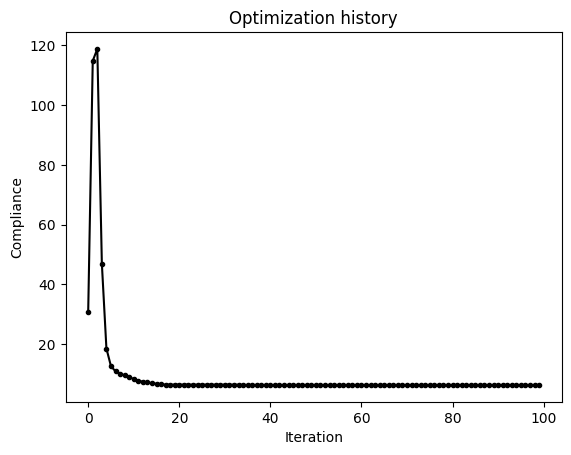

In [4]:
plt.plot(comp, ".-k")
plt.title("Optimization history")
plt.xlabel("Iteration")
plt.ylabel("Compliance")
plt.show()

In [5]:
# Solve
u, f, _, _, _ = cantilever.solve()
cantilever.plot(u[:, 0:3], element_property={"t": cantilever.thickness}, thickness=True)

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…